In [154]:
import pandas as pd
from scipy import stats
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

In [156]:
# Load the dataset
data = pd.read_csv("Microsoft_malware_dataset_min.csv")

# Display general information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   HasDetections               100000 non-null  int64  
 1   Wdft_IsGamer                96585 non-null   float64
 2   Census_IsVirtualDevice      99815 non-null   float64
 3   Census_OSEdition            100000 non-null  object 
 4   Census_HasOpticalDiskDrive  100000 non-null  int64  
 5   Firewall                    98924 non-null   float64
 6   SMode                       94068 non-null   float64
 7   IsProtected                 99609 non-null   float64
 8   OsPlatformSubRelease        100000 non-null  object 
 9   CountryIdentifier           100000 non-null  int64  
dtypes: float64(5), int64(3), object(2)
memory usage: 7.6+ MB


In [157]:
# Display basic statistics
description = data.describe()
description

,HasDetections,Wdft_IsGamer,Census_IsVirtualDevice,Census_HasOpticalDiskDrive,Firewall,SMode,IsProtected,CountryIdentifier
count,100000.000000,96585.000000,99815.000000,100000.000000,98924.000000,94068.000000,99609.000000,100000.000000
mean,0.499280,0.281607,0.006642,0.075850,0.977326,0.000351,0.944864,108.188050
std,0.500002,0.449785,0.081230,0.264759,0.148863,0.018727,0.228246,62.989406
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,51.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,97.000000
75%,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,162.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,222.000000


In [158]:
# Checking for missing values.
data.isnull().sum()

HasDetections                    0
Wdft_IsGamer                  3415
Census_IsVirtualDevice         185
Census_OSEdition                 0
Census_HasOpticalDiskDrive       0
Firewall                      1076
SMode                         5932
IsProtected                    391
OsPlatformSubRelease             0
CountryIdentifier                0
dtype: int64

In [161]:
# Drop rows with missing values in specific columns
columns_to_check = ["Wdft_IsGamer", "Census_IsVirtualDevice", "Firewall", "SMode", "IsProtected"]
data_cleaned = data.dropna(subset = columns_to_check)

data_cleaned.isnull().sum()

HasDetections                 0
Wdft_IsGamer                  0
Census_IsVirtualDevice        0
Census_OSEdition              0
Census_HasOpticalDiskDrive    0
Firewall                      0
SMode                         0
IsProtected                   0
OsPlatformSubRelease          0
CountryIdentifier             0
dtype: int64

In [163]:
# Remove duplicates 
data_cleaned= data_cleaned.drop_duplicates()

In [165]:
z_scores = stats.zscore(data_cleaned.select_dtypes(include = [np.number]))
abs_z_scores = abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_data = data_cleaned[filtered_entries]

In [168]:
new_data

,HasDetections,Wdft_IsGamer,Census_IsVirtualDevice,Census_OSEdition,Census_HasOpticalDiskDrive,Firewall,SMode,IsProtected,OsPlatformSubRelease,CountryIdentifier
0,0,0.0,0.0,Professional,0,1.0,0.0,1.0,rs4,29
1,0,0.0,0.0,Professional,0,1.0,0.0,1.0,rs4,93
2,0,0.0,0.0,Core,0,1.0,0.0,1.0,rs4,86
3,1,0.0,0.0,Professional,0,1.0,0.0,1.0,rs4,88
4,1,0.0,0.0,Core,0,1.0,0.0,1.0,rs4,18
...,...,...,...,...,...,...,...,...,...,...
99898,0,0.0,0.0,Professional,0,1.0,0.0,1.0,rs3,22
99899,0,0.0,0.0,Professional,0,1.0,0.0,1.0,th2,121
99927,0,1.0,0.0,Core,1,1.0,0.0,1.0,rs4,142
99943,0,1.0,0.0,Core,1,1.0,0.0,1.0,rs4,214


In [169]:
#Retrieving and Saving all categorical data into a variable
categories = new_data.select_dtypes(include="object").columns

categories

Index(['Census_OSEdition', 'OsPlatformSubRelease'], dtype='object')

In [172]:
encoder = LabelEncoder() #instantiate the label encoder class

for col in categories: 
    print(f"Encoding {col}") 
    new_data.loc[:, col] = encoder.fit_transform(new_data[col])

Encoding Census_OSEdition
Encoding OsPlatformSubRelease


In [174]:
# Define features and target variable
features = new_data.drop("HasDetections", axis=1)
label = new_data["HasDetections"]

# Split the dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.2)

In [176]:
# Train the model
model = DecisionTreeClassifier()
model.fit(x_train, y_train)

DecisionTreeClassifier()

In [178]:
# Predict probabilities
y_pred_prob = model.predict_proba(x_test)[:,1]
y_pred = model.predict(x_test)

y_pred_prob
y_pred

array([0, 1, 0, ..., 1, 1, 1], dtype=int64)

In [180]:
# Classification report
print(classification_report(y_test, y_pred))

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

              precision    recall  f1-score   support

           0       0.31      0.33      0.32      1363
           1       0.19      0.17      0.18      1240

    accuracy                           0.26      2603
   macro avg       0.25      0.25      0.25      2603
weighted avg       0.25      0.26      0.25      2603

Accuracy: 0.26


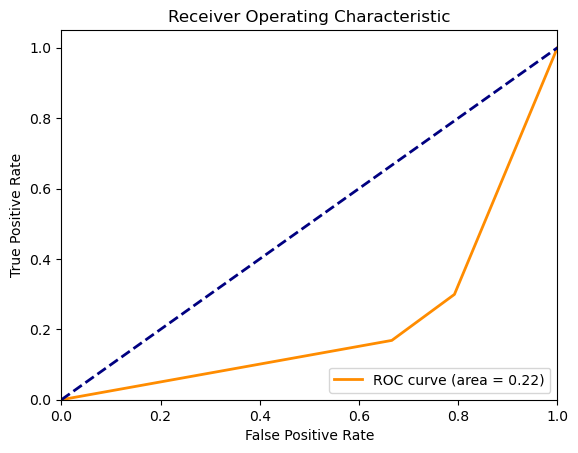

In [182]:
# Compute ROC curve 
fpr, tpr, _ = roc_curve(y_test, y_pred_prob) 
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color = "darkorange", lw = 2, label = "ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color = "navy", lw = 2, linestyle = "--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc = "lower right")
plt.show()

In [184]:
# Tune hyperparameters using GridSearchCV
param_grid = {
    "max_depth": [3, 5, 7, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3, scoring = "roc_auc")
grid_search.fit(x_train, y_train)

# Best hyperparameters
grid_search.best_params_

{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [185]:
# Define the model with the best parameters found
best_model = DecisionTreeClassifier(max_depth = 3, min_samples_split = 10, min_samples_leaf = 1)
best_model.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_split=10)

In [186]:
# Predict probabilities
y_pred_prob2 = best_model.predict_proba(x_test)[:, 1]

# Predict class labels
y_pred2 = best_model.predict(x_test)

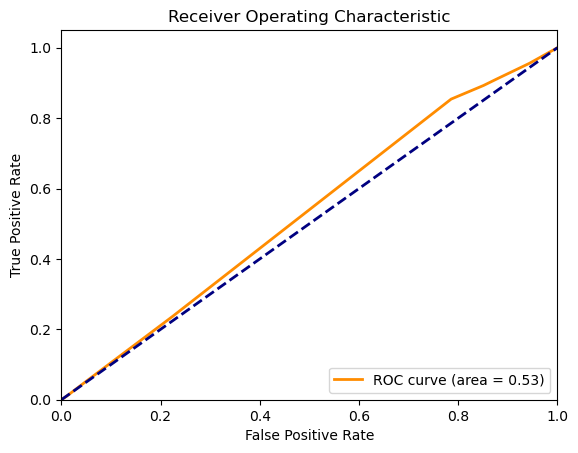

In [190]:
# Compute ROC curve and ROC AUC score
fpr, tpr, _ = roc_curve(y_test, y_pred_prob2)
roc_auc = roc_auc_score(y_test, y_pred_prob2)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color = "darkorange", lw = 2, label = "ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color = "navy", lw=2, linestyle = "--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc = "lower right")
plt.show()

In [192]:
# Classification report
print(classification_report(y_test, y_pred2))

# Accuracy score
accuracy = accuracy_score(y_test, y_pred2)
print(f"Accuracy: {accuracy:.2f}")

              precision    recall  f1-score   support

           0       0.53      0.78      0.63      1363
           1       0.49      0.24      0.32      1240

    accuracy                           0.52      2603
   macro avg       0.51      0.51      0.47      2603
weighted avg       0.51      0.52      0.48      2603

Accuracy: 0.52


In [194]:
data_unsupervised = new_data.drop("HasDetections", axis=1)

In [196]:
data_unsupervised

,Wdft_IsGamer,Census_IsVirtualDevice,Census_OSEdition,Census_HasOpticalDiskDrive,Firewall,SMode,IsProtected,OsPlatformSubRelease,CountryIdentifier
0,0.0,0.0,11,0,1.0,0.0,1.0,4,29
1,0.0,0.0,11,0,1.0,0.0,1.0,4,93
2,0.0,0.0,1,0,1.0,0.0,1.0,4,86
3,0.0,0.0,11,0,1.0,0.0,1.0,4,88
4,0.0,0.0,1,0,1.0,0.0,1.0,4,18
...,...,...,...,...,...,...,...,...,...
99898,0.0,0.0,11,0,1.0,0.0,1.0,3,22
99899,0.0,0.0,11,0,1.0,0.0,1.0,6,121
99927,1.0,0.0,1,1,1.0,0.0,1.0,4,142
99943,1.0,0.0,1,1,1.0,0.0,1.0,4,214


In [198]:
model = KMeans(n_clusters=5)

clust_label = model.fit_predict(new_data)

In [201]:
kmeans_pred = pd.DataFrame(clust_label)
kmeans_pred

,0
0,1
1,3
2,3
3,3
4,1
...,...
13009,1
13010,2
13011,2
13012,0
